# Cross-validation

With the code developed so far, it is possible to train an ANN and provide an estimate of the results it would offer in its real execution (with unseen patterns, represented by a test set). However, in this last aspect there are two factors to consider, as a consequence of the non-deterministic nature of the process we are following:

- The partitioning of the set of patterns into training/test is random (hold out), and is therefore overly dependent on good or bad luck in choosing training and test patterns.
- ANN training is not deterministic, as the initialisation of the weights is random. As before, it is too dependent on good or bad luck to start the training at a good or bad starting point.

For these two reasons, the test result of a single training is not significant when assessing the goodness of fit of the model in the presence of unseen patterns. To solve this problem, the experiment is repeated several times and the results are averaged. This can be implemented in a simple way by means of a loop; however, it is necessary to do this in an orderly way as there are two different sources of randomness.

Firstly, to minimise the randomness due to the partitioning of the data set, it is necessary to have a method that ensures that each data is used for training at least once, and for testing at least once. The most commonly used method is cross-validation. In this method, the data set is split into k disjoint subsets and k experiments are performed. In the k-th experiment, the k subset is separated for testing, and the remaining k-1 substes are used for training, performing a k-fold cross-validation. A common value is k=10, which gives a 10-fold cross-validation. Finally, the test value corresponding to the appropriate metric will be the average value of the values of the k experiments.

A widely used variant of cross-validation is stratified cross-validation. In this case, each subset is created in such a way as to keep the proportion of patterns of each class the same (or similar) as in the original dataset. This is particularly used when the data set is imbalanced.

It is usual to save not only the mean, but also the k values, in order to subsequently perform a paired hypothesis test with another model. To do this, it is necessary that both models have been trained using the same training and test sets.

This way of evaluating the model is often considered to be slightly pessimistic, i.e. the results obtained in tests are slightly worse than those that would be obtained from real training with all available data. In a hold out experiment, as mentioned above, several data are separated for testing. This means that the model is trained with less data than is available, and that by chance the data separated for testing can be of great importance (especially if there is little data). For this reason, when training with less data and possibly no "important" data, hold out is considered a pessimistic assessment. In the same way, cross-validation also separates data for testing, so it does not train on all available data, and is therefore also pessimistic. However, it is guaranteed that all data are used at least once in training and once in testing, thus trying to minimise the impact of chance in separating data, so it is considered only a slightly pessimistic evaluation.

Doing this is as simple as splitting the data set and performing a loop with k iterations in which at the k-th iteration a model is trained and evaluated with the corresponding sets. However, if the model is not deterministic, the result obtained at the k-th iteration will not be meaningful, since it is again dependent on chance. In this case, what needs to be done is a second nested loop within iteration k in which the model is repeatedly trained, and finally an average of the results is made to finally output the result of iteration k. The number of trainings must be high for the average results to be really significant, at least 50 trainings.

### Question

If this second loop is performed with a deterministic model, what will be the standard deviation of the test results obtained? Is there a difference between performing this second loop and averaging the results, or doing a single training?

`A deterministic model will produce the same output for the same input every time, resulting in the same model for all trainings. Therefore, the outputs produced by those models will be identical, resulting in a mean of all the results that is the same as the result of a single model, with a standard deviation of zero. As a result, a deterministic model only needs to be trained once. However, it is still useful to perform multiple trainings of a deterministic model in order to reduce the impact of random initialization of the weights on the final results. By averaging the results over multiple trainings, you can produce a more stable and reliable estimate of the model's performance.`

`If the second loop is performed with a deterministic model, the standard deviation of the test results obtained will be zero, since the model will produce the same output for the same input every time. There is a difference between performing the second loop and averaging the results, and doing a single training. Averaging the results over multiple trainings with different initializations of the weights reduces the impact of the random initialization of the weights on the final results, which can help to produce a more stable and reliable estimate of the model's performance.`

In this way, it is possible to evaluate a model together with its hyperparameters in solving a problem. A very common situation is to compare several models (or the same model with different hyperparameters), for which this scheme has to be applied with an important caveat: the sets used in the cross-validation must be the same for each model. Since the distribution of patterns in different sets is random, having the same subsets in different runs is achieved by setting the random seed at the beginning of the program to be executed. Setting the random seed not only allows the same subsets to be generated, but is also important in order to be able to repeat the results in different runs.

It is also important to bear in mind that this methodology allows estimating the real performance of a model (although slightly pessimistic). The final model that would be used in production would be the result of training it with all the available patterns, since, as seen in the theory class, and very generally speaking, the more patterns you train with, the better the model will be.

In this assignment, you are asked to:

1. Develop a function called `crossvalidation` that receives a value `N` (equal to the number of patterns), and a value `k` (number of subsets into which the dataset is to be split), and returns a vector of length N, where each element indicates in which subset that pattern should be included.

    To do this function, one possibility is to perform the following steps:
    
    - Create a vetor with k sorted elements, from 1 to k.
    - Create a new vector with repetitions of the previous vector until its length is greater than or equal to N. The functions `repeat` and `ceil` can be used for this purpose.
    - Take the first N values of this vector.
    - Shuffle this vector (using the function `shuffle!` and return it. To use this function, the module `Random` should be loaded.
    
    No loop function should be used in the developed function.

In [1]:
using Random;

# Define a function that performs k-fold cross-validation
# N: the number of patterns
# k: the number of folds
function crossvalidation(N::Int64, k::Int64)
    # Calculate the number of patterns in each fold
    fold_size = ceil(Int, N / k)
    # Repeat the indices of the folds k times
    idx = repeat(1:k, fold_size)[1:N]
    # Shuffle the indices randomly
    shuffle!(idx)
    # Return the shuffled indices
    return idx
end

idx = crossvalidation(150, 10)

150-element Vector{Int64}:
 7
 3
 3
 8
 9
 2
 7
 7
 6
 9
 5
 3
 9
 ⋮
 1
 6
 7
 2
 8
 1
 2
 2
 8
 7
 4
 6

2. Create a new function called `crossvalidation`, which in this case receives as first argument `targets` of type `AbstractArray{Bool,2}` with the desired outputs, and as second argument a value `k` (number of subsets in which the dataset will be split), and returns a vector of length N (equal to the number of rows of targets), where each element indicates in which subset that pattern must be included. This partition has also to be stratified. To do this, the following steps can be followed:

    - Create a vector of indices, with as many values as rows in the `target` matrix.
    - Write a loop that iterates over the classes (columns in the `target` matrix), and does the following:
        - Take the number of elements belonging to that class. This can be done by making a call to the `sum` function applied to the corresponding column.
        - Make a call to the `crossvalidation` function developed earlier passing as parameters this number of elements and the value of k.
        - Update the index vector positions indicated by the corresponding column of the `targets` matrix with the values of the vector resulting from the call to the `crossvalidation` function.
        
        ### Question
        
        Could you perform these 3 operations in a single line of code?
        
        ```It is possible to perform these 3 operations in a single line of code using Julia's broadcasting features.```
        </br>
    - Return the vector of indices.
    
    As it can be seen in this explanation, a loop iterating all classes can be used in this function. However, you need to make sure that each class has at least k patterns. A usual value is k=10. Therefore, it is important to make sure that you have at least 10 patterns of each class.
        
    ### Question
    
    What would happen if any class has a number of patterns less than k? What would be the consequences for calculating metrics?
    
    ```If any class has a number of patterns less than k, then it would not be possible to perform k-fold cross-validation in a stratified manner. This is because k-fold cross-validation requires that each fold contains roughly the same proportion of each class. If a class has fewer patterns than k, then it would not be possible to split the patterns into k folds while maintaining the same proportion of that class in each fold. As a consequence, there will be splits without patterns for that class, since the function `crossvalidation` will cut the vector of k elements with the first N positions (k > N = nº instances). This way, the indices for the last k - N splits will have no patterns for that class. The value of the metrics for that class will be equal to 0 for some iterations of the cross-validation. This can lead to biased or unreliable evaluation metrics, especially if the class with fewer patterns is the positive class in a binary classification problem. In such cases, it may be necessary to use alternative evaluation metrics that are less sensitive to imbalanced class distributions, such as the area under the receiver operating characteristic curve (AUC-ROC) or the precision-recall curve. Alternatively, we could consider using a different cross-validation strategy that takes into account the imbalanced class distribution, such as leave-one-out cross-validation.```
    
    > If, for whatever reason, it is impossible to ensure that you have at least 10 patterns of each class, one possibility would be to lower the value of k. In this case, consult with the teacher to assess this option, and what impact it might have on the final result of the trained models. In this case, consult with the teacher to assess this option, and what impact it might have on the final result of the trained models.

In [2]:
# Perform stratified k-fold cross-validation on a binary matrix of targets
# targets: a binary matrix of targets, where each row represents a pattern and each column represents a class
# k: the number of folds to use in the cross-validation
function crossvalidation(targets::AbstractArray{Bool,2}, k::Int64)
    # Check that there are enough instances per class to perform k-fold cross-validation
    @assert all(sum(targets, dims=1) .>= k) "There are not enough instances per class to perform a $(k)-fold cross-validation"
    
    # Initialize the index vector to zeros
    idx = Int.(zeros(size(targets, 1)))
    
    # Iterate over the classes and perform stratified k-fold cross-validation
    for class in 1:size(targets, 2)
        # Find the indices of the patterns that belong to the current class
        class_indices = findall(targets[:, class])
        # Perform stratified k-fold cross-validation on the patterns that belong to the current class
        class_folds = crossvalidation(length(class_indices), k)
        # Update the index vector with the indices of the folds for the current class
        idx[class_indices] .= class_folds
    end
    
    # Return the index vector
    return idx
end;


# Generate some test data
num_classes = 4
num_patterns = 100
targets = falses(num_patterns, num_classes)

for i in 1:num_patterns
    label = rand(1:num_classes)
    targets[i, label] = true
end

# Call the crossvalidation function
idx = crossvalidation(targets, 10)

100-element Vector{Int64}:
  1
  1
  7
  7
  1
  7
  8
  9
  5
  5
  1
  1
  5
  ⋮
  1
  2
 10
  3
  5
 10
  9
  2
  7
  3
  1
  8

3. Perform a final function called crossvalidation, but in this case with the first parameter `targets` of type `AbstractArray{<:Any,1}` (i.e. a vector with heterogeneous elements), the same second argument, and perform stratified cross-validation.

    In this case, the steps to follow in this function are not specified. However, they are similar to the previous one. A simple way to do it would be to call the function `oneHotEncoding` passing the vector `targets` as an argument.
    
      ### Question
      
      Could you develop this function without calling oneHotEncoding?
      
      ```Yes, we can. It's shown down below:```

In [3]:
include("functions.jl")
    
function crossvalidation(targets::AbstractArray{<:Any,1}, k::Int64)
    # Convert the targets to a binary matrix using one-hot encoding
    binary_targets = oneHotEncoding(targets)
    # Perform stratified k-fold cross-validation on the binary matrix
    idx = crossvalidation(binary_targets, k)
    return idx
end


# Generate some test data
N = 100
targets = rand(["c1", "c2", "c3"], N)

# Call the crossvalidation function
idx = crossvalidation(targets, 5);

In [4]:
"""
# Perform stratified k-fold cross-validation on a vector of targets w/o using oneHotEncoding
# targets: a vector of targets, where each element represents a class
# k: the number of folds to use in the cross-validation
function crossvalidation(targets::AbstractArray{<:Any,1}, k::Int64)
    # Get the unique classes in the targets vector
    classes = unique(targets)
    # Initialize the index vector to zeros
    idx = Int.(zeros(length(targets)))
    
    # Iterate over the classes and perform stratified k-fold cross-validation
    for class in classes
        # Find the indices of the patterns that belong to the current class
        classIdx = (targets .== class)
        # Count the number of instances in the current class
        numInstances = sum(classIdx)
        # Check that there are enough instances per class to perform k-fold cross-validation
        @assert (numInstances .>= k) "There are not enough instances per class to perform a $(k)-fold cross-validation"
        # Perform stratified k-fold cross-validation on the patterns that belong to the current class
        classFolds = crossvalidation(numInstances, k)
        # Update the index vector with the indices of the folds for the current class
        idx[classIdx] .= classFolds
    end
    
    # Return the index vector
    return idx
end
"""

LoadError: UndefVarError: `k` not defined

In [5]:
"""
function crossvalidation_without_onehot(targets::AbstractArray{<:Any,1}, k::Int64)
    num_samples = length(targets)
    fold_sizes = div(num_samples, k)
    remainder = mod(num_samples, k)

    # Randomly shuffle the indices of the samples
    shuffled_indices = shuffle(1:num_samples)

    indices = []

    for i in 1:k
        fold_size = fold_sizes + (i <= remainder ? 1 : 0)
        fold_indices = shuffled_indices[1:fold_size]
        push!(indices, fold_indices)
        shuffled_indices = shuffled_indices[fold_size + 1:end]
    end

    return indices
end

# Generate some test data
N = 20
targets = rand(["c1", "c2", "c3"], N)

# Call the crossvalidation function
idx = crossvalidation(targets, 3)

"""

"function crossvalidation_without_onehot(targets::AbstractArray{<:Any,1}, k::Int64)\n    num_samples = length(targets)\n    fold_sizes = div(num_samples, k)\n    remainder = mod(num_samples, k)\n\n    # Randomly shuffle the indices of the samples\n    shuffled_indices = shuffle" ⋯ 169 bytes ⋯ "  push!(indices, fold_indices)\n        shuffled_indices = shuffled_indices[fold_size + 1:end]\n    end\n\n    return indices\nend\n\n# Generate some test data\nN = 20\ntargets = rand([\"c1\", \"c2\", \"c3\"], N)\n\n# Call the crossvalidation function\nidx = crossvalidation(targets, 3)\n\n"

4. Integrate these functions into the code developed so far and define two functions to train ANNs following the stratified cross-validation strategy. To do this:

- First, it is necessary to set the random seed to ensure that the experiments are repeatable. This can be done with the `seed!` function of the `Random` module.
- Once the data is loaded and encoded, generate an index vector by calling the `crossvalidation` function.
- Create a function called `trainClassANN`, which receives as parameters the topology, the training set and the indices used for cross-validation. Optionally, it can receive the rest of the parameters used in previous assignments. Inside this function, the following steps may be followed:
    - Create a vector with k elements, which will contain the test results of the cross-validation process with the selected metric. If more than one metric is to be used, create one vector per metric.
    - Make a loop with k iterations (k folds) where, within each iteration, 4 matrices are created from the desired input and output matrices by means of the index vector resulting from the previous function. Namely, the desired inputs and outputs for training and test. As always, do this process of creating new matrices without loops.
    - Within this loop, add a call to generate the model with the training set, and test with the corresponding test set according to the value of k. This can be done by calling the `trainClassANN` function developed in previous assignments, passing as parameters the corresponding sets.
    - As indicated in the previous assignment, the training of ANNs is not deterministic, so that, for each iteration k of the cross-validation, it will be necessary to train several ANNs and return the average of the test results (with the selected metric or metrics) in order to have the test value corresponding to this k.
    - Furthermore, in the case of training ANNs, the training set can be split into training and validation if the ratio of patterns to be used for the validation set is greater than 0. To do this, use the `holdOut` function developed in a previous assignment.
    - Once the model has been trained (several times) on each fold, take the result and fill in the vector(s) created earlier (one for each metric).
    - Finally, provide the result of averaging the values of these vectors for each metric together with their standard deviations.
    - As a result of this call, at least the test value in the selected metric(s) should be returned. If the model is not deterministic (as is the case for the ANNs), it will be the average of the results of several trainings.
- Once this function is done, develop a second one, of the same name, so that it accepts as desired outputs a vector instead of an array, as in a previous assignment, and its operation is simply to make a call to this newly developed function.

> **Remarks**:
> - Although we have only seen how to train ANNs, in the next assignment we will use other models contained in another library (Scikit-Learn). The idea is to use the same code used for cross-validation with this global loop, changing only the line in which the model is generated.
> - Note that other Machine Learning models are deterministic, so they do not need the inner loop (whenever they are trained with the same data they return the same outputs), but only the loop for each fold.

In [6]:
using Random
using Statistics

function trainClassANN(topology::AbstractArray{<:Int,1}, 
        trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}}, 
        kFoldIndices::Array{Int64,1}; 
        transferFunctions::AbstractArray{<:Function,1}=fill(σ, length(topology)), 
        maxEpochs::Int=1000, minLoss::Real=0.0, learningRate::Real=0.01, repetitionsTraining::Int=1, 
        validationRatio::Real=0.0, maxEpochsVal::Int=20)

    kFolds = maximum(kFoldIndices)
    testAccuracies = Array{Float64, 1}(undef, kFolds)

    (inputs, targets) = trainingDataset

    for numFold in 1:kFolds
        trainingInputs, trainingTargets, testInputs, testTargets = splitDataForFold(inputs, targets, kFoldIndices, numFold)

        testAccuraciesForEachRepetition = trainAndEvaluateRepetitions(
            topology, trainingInputs, trainingTargets, testInputs, testTargets,
            transferFunctions, maxEpochs, minLoss, learningRate,
            repetitionsTraining, maxEpochsVal, validationRatio
        )

        testAccuracies[numFold] = mean(testAccuraciesForEachRepetition)
    end

    return mean(testAccuracies), std(testAccuracies)
end

function splitDataForFold(inputs, targets, kFoldIndices, numFold)
    trainingInputs = inputs[kFoldIndices .!= numFold, :]
    trainingTargets = targets[kFoldIndices .!= numFold, :]
    testInputs = inputs[kFoldIndices .== numFold, :]
    testTargets = targets[kFoldIndices .== numFold, :]
    return trainingInputs, trainingTargets, testInputs, testTargets
end

function splitTrainAndValidation(inputs, targets, validationRatio)
    (trainingIndexes, validationIndexes) = holdOut(size(inputs, 1), validationRatio)
    validationInputs = inputs[validationIndexes,:]
    validationTargets = targets[validationIndexes,:]
    trainingInputs = inputs[trainingIndexes,:]
    trainingTargets = targets[trainingIndexes,:]

    return trainingInputs, trainingTargets, validationInputs, validationTargets
end

function trainAndEvaluateRepetitions(topology, inputs, targets, testInputs, testTargets, transferFunctions, maxEpochs, minLoss, learningRate, repetitionsTraining, maxEpochsVal, validationRatio)
    testAccuraciesForEachRepetition = Array{Float64, 1}(undef, repetitionsTraining)

    for repetition in 1:repetitionsTraining
        # Split training set into training and validation sets if validation ratio is greater than 0
            if validationRatio > 0.0

                # Split training set into training and validation sets
                trainingInputs, trainingTargets, validationInputs, validationTargets =splitTrainAndValidation(inputs, targets, validationRatio)

                # Train model with current fold and repetition using training and validation sets
                model, _ = trainClassANN(topology, (trainingInputs, trainingTargets);
                    validationDataset = (validationInputs, validationTargets),
                    transferFunctions = transferFunctions, maxEpochs = maxEpochs,
                    minLoss = minLoss, learningRate = learningRate, maxEpochsVal = maxEpochsVal
                )

            else

                # Train model with current fold and repetition using only training set
                model, _ = trainClassANN(topology, (trainingInputs, trainingTargets);
                    transferFunctions = transferFunctions, maxEpochs = maxEpochs,
                    minLoss = minLoss, learningRate = learningRate, maxEpochsVal = maxEpochsVal
                )

            end
        
        outputs = model(testInputs')'
        testAccuraciesForEachRepetition[repetition] = accuracy(outputs, testTargets)
    end

    return testAccuraciesForEachRepetition
end

trainAndEvaluateRepetitions (generic function with 1 method)

In [7]:
function trainClassANN(topology::AbstractArray{<:Int,1},
        trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,1}},
        kFoldIndices::	Array{Int64,1};
        transferFunctions::AbstractArray{<:Function,1}=fill(σ, length(topology)),
        maxEpochs::Int=1000, minLoss::Real=0.0, learningRate::Real=0.01,repetitionsTraining::Int=1, 
        validationRatio::Real=0.0, maxEpochsVal::Int=20)

    # Unpack inputs and targets from training dataset
    inputs, targets = trainingDataset

    # Reshape targets to be a column vector
    targets = reshape(targets, :, 1)

    # Call trainClassANN with inputs, targets, and kFoldIndices
    return trainClassANN(topology, (inputs, targets), kFoldIndices;
        transferFunctions = transferFunctions, maxEpochs = maxEpochs, minLoss = minLoss,
        learningRate = learningRate, repetitionsTraining = repetitionsTraining,
        validationRatio = validationRatio, maxEpochsVal = maxEpochsVal
    )
end

trainClassANN (generic function with 4 methods)

In [11]:
include("functions.jl")

using DelimitedFiles

Random.seed!(42)

# Load dataset
dataset = readdlm("iris.data", ',')

# Define learning rate and maximum number of epochs
learningRate = 0.01
numMaxEpochs = 1000

# Extract inputs and targets from dataset
inputs = convert(Array{Float32,2}, dataset[:,1:4])
normalizeMinMax!(inputs)
targets = oneHotEncoding(dataset[:,5])

# Define number of cross-validation folds
kFolds = 10
crossValidationIndexes = crossvalidation(targets, kFolds)

# Initialize vectors to store results
testAccuracies = []
testAccuraciesStd = []

# Define neural network topologies
topologies = []

for i in 1:15
    push!(topologies, [i])
    push!(topologies, [i, i])
end

# Train and evaluate models for each topology
for topology in topologies
    print(topology)
    # Train model with cross-validation
    testAccuracy, testAccuracyStd = trainClassANN(
        topology, (inputs, targets), crossValidationIndexes;
        maxEpochs = numMaxEpochs, learningRate = learningRate, repetitionsTraining=10, validationRatio=0.0
    )

    println(testAccuracy)

    # Store results
    push!(testAccuracies, testAccuracy)
    push!(testAccuraciesStd, testAccuracyStd)
end

[1]0.9640000000000001
[1, 1]0.8553333333333335
[2]0.9673333333333334
[2, 2]0.9593333333333336
[3]0.9646666666666668
[3, 3]0.9593333333333334
[4]0.9633333333333333
[4, 4]0.9600000000000002
[5]0.9593333333333334
[5, 5]0.9526666666666668
[6]0.9600000000000002
[6, 6]0.9526666666666668
[7]0.9553333333333335
[7, 7]0.9506666666666668
[8]0.958
[8, 8]0.9506666666666668
[9]0.9553333333333335
[9, 9]0.9473333333333335
[10]0.9553333333333335
[10, 10]0.9413333333333334
[11]0.9566666666666667
[11, 11]0.9433333333333334
[12]0.9593333333333334
[12, 12]0.9460000000000003
[13]0.9580000000000002
[13, 13]0.9380000000000001


LoadError: InterruptException:

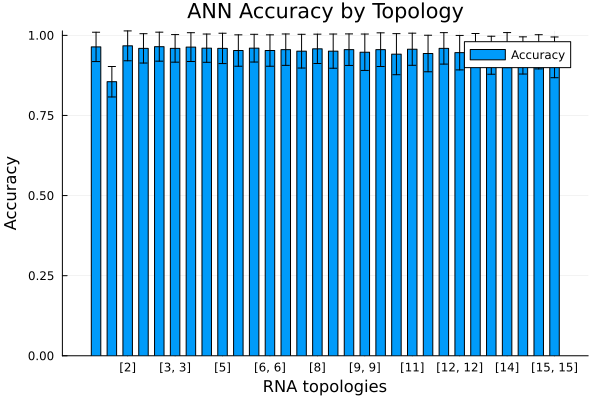

In [9]:
# Import necessary packages
using Plots

# Convert topologies to strings for plotting
text_topologies = ["[" * join(map(string, sublist), ", ") * "]" for sublist in topologies]

# Create bar plot of test accuracies with error bars
plt = bar(text_topologies, testAccuracies, yerror=testAccuraciesStd, label="Accuracy", legend=:topright,
    title="ANN Accuracy by Topology",
    xlabel="RNA topologies", ylabel="Accuracy", bar_width=0.6)

# Display plot
display(plt)

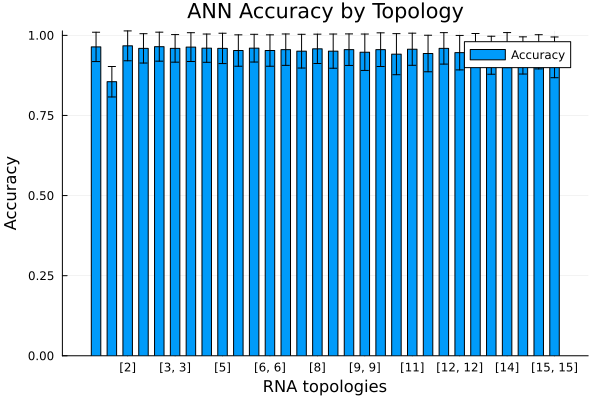

In [10]:
# Import necessary packages
using Plots

# Convert topologies to strings for plotting
text_topologies = ["[" * join(map(string, sublist), ", ") * "]" for sublist in topologies]

# Create bar plot of test accuracies with error bars
plt = bar(text_topologies, testAccuracies, yerror=testAccuraciesStd, label="Accuracy", legend=:topright,
    title="ANN Accuracy by Topology",
    xlabel="RNA topologies", ylabel="Accuracy", bar_width=0.6)

# Display plot
display(plt)